In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/dataset/github_comments_filtered.csv
/kaggle/input/vader-implement/git_final_vadar.csv


In [2]:
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')  # Ensure compatibility with WordNet


[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...


True

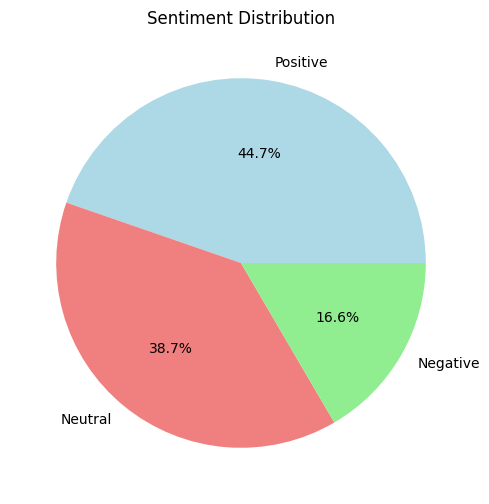

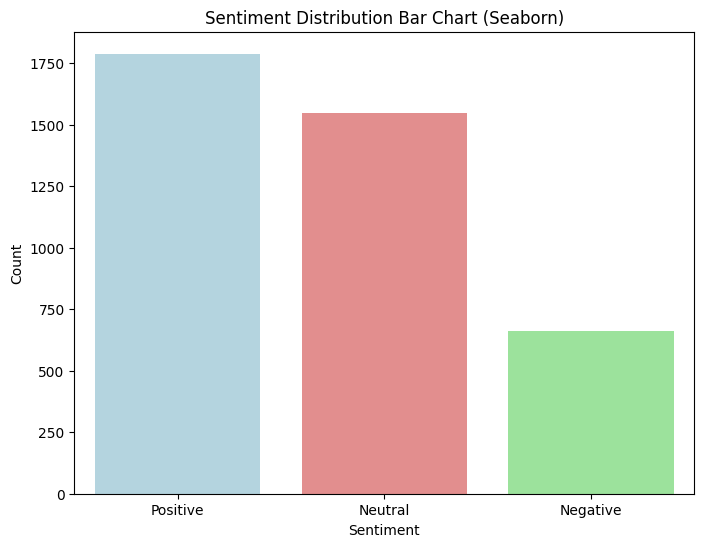

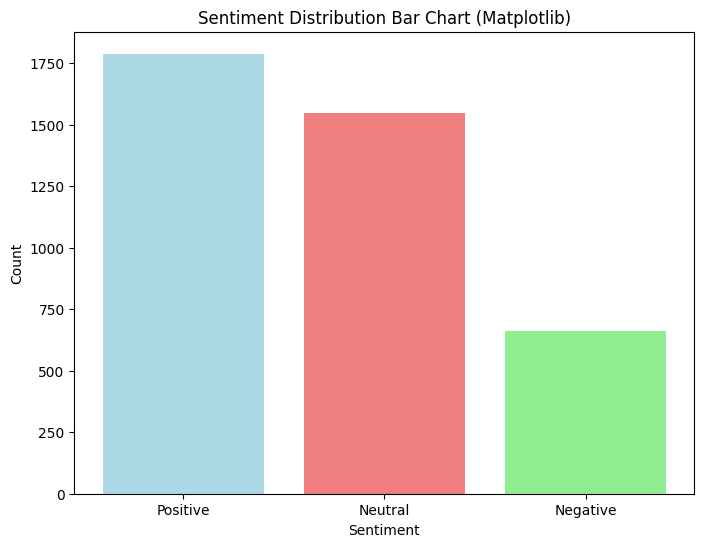

SVM Model Accuracy: 0.80
Classification Report:
               precision    recall  f1-score   support

    Negative       0.81      0.44      0.57       133
     Neutral       0.78      0.89      0.83       310
    Positive       0.81      0.84      0.83       357

    accuracy                           0.80       800
   macro avg       0.80      0.73      0.74       800
weighted avg       0.80      0.80      0.79       800



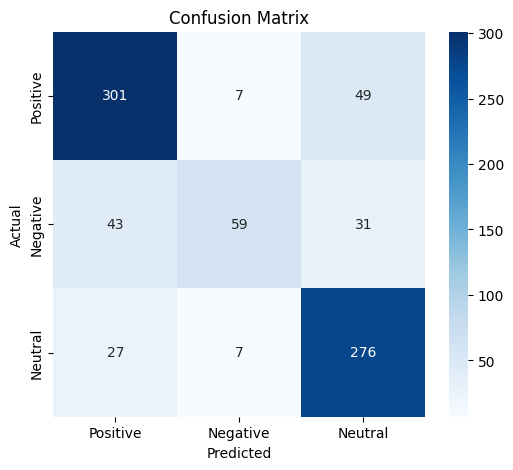

Results saved to svm_sentiment_results.csv


In [3]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
from textblob import TextBlob
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

file_path = "/kaggle/input/dataset/github_comments_filtered.csv"
df = pd.read_csv(file_path)

def clean_text(comment):
    if not isinstance(comment, str) or comment.strip() == "":
        return ""
    comment = comment.lower()
    comment = re.sub(r'@\w+', '', comment)
    comment = re.sub(r'http\S+|www\S+', '', comment)
    comment = re.sub(r'\s+', ' ', comment)
    comment = re.sub(r'[^\w\s.,!?]', '', comment)
    comment = re.sub(r'(.)\1{2,}', r'\1\1', comment)
    return comment.strip()

df['Processed_Comment'] = df['Comment'].astype(str).apply(clean_text)

def get_sentiment(text):
    polarity = TextBlob(text).sentiment.polarity
    if polarity > 0:
        return "Positive"
    elif polarity < 0:
        return "Negative"
    else:
        return "Neutral"

df['Sentiment'] = df['Processed_Comment'].apply(get_sentiment)

plt.figure(figsize=(6,6))
df['Sentiment'].value_counts().plot.pie(autopct='%1.1f%%', colors=["lightblue", "lightcoral", "lightgreen"])
plt.title("Sentiment Distribution")
plt.ylabel("")
plt.show()

plt.figure(figsize=(8,6))
sns.barplot(x=df['Sentiment'].value_counts().index, y=df['Sentiment'].value_counts().values, palette=["lightblue", "lightcoral", "lightgreen"])
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.title("Sentiment Distribution Bar Chart (Seaborn)")
plt.show()

plt.figure(figsize=(8,6))
sentiment_counts = df['Sentiment'].value_counts()
plt.bar(sentiment_counts.index, sentiment_counts.values, color=["lightblue", "lightcoral", "lightgreen"])
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.title("Sentiment Distribution Bar Chart (Matplotlib)")
plt.show()

X = df['Processed_Comment']
y = df['Sentiment']

vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1,2))
X_vectorized = vectorizer.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_vectorized, y, test_size=0.2, random_state=42, stratify=y)

param_grid = {'C': [0.1, 1, 10], 'gamma': ['scale', 'auto']}
svm = SVC(kernel='linear', random_state=42)
grid_search = GridSearchCV(svm, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

best_svm_model = grid_search.best_estimator_
best_svm_model.fit(X_train, y_train)

y_pred = best_svm_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"SVM Model Accuracy: {accuracy:.2f}")
print("Classification Report:\n", classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred, labels=["Positive", "Negative", "Neutral"])
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Positive", "Negative", "Neutral"], yticklabels=["Positive", "Negative", "Neutral"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

results_df = pd.DataFrame({
    "Original_Comment": df.loc[y_test.index, "Comment"],
    "Processed_Comment": df.loc[y_test.index, "Processed_Comment"],
    "Actual_Sentiment": y_test.values,
    "Predicted_Sentiment": y_pred
})

output_file = "svm_sentiment_results.csv"
results_df.to_csv(output_file, index=False)
print(f"Results saved to {output_file}")
